# Ex 1 - Implementations of Spectral Graph Partitioning for community detection

### Comparing the algorithms

##### Low Rank Representation

    the low rank representation can capture the structure of a graph very accurately, and can be adjusted with the number of eigenvectors to use. Reducing this, can speed up the clustering process but get a less accurate clustering.

##### Scikit-learn Spectral Clustering

    very high-level implementation, performing a graph cut on a similarity matrix from the original graph. Although it is easy to use and has customizable parameters, the performance might decrease with large graphs.

##### Spark Power Iteration Clustering

    it is a distributed algorithm designed for large-scale graphs, scaling efficiently. 


Comparing the 3 methods, you can use either low rank or scikit-learn for small/medium sized graphs and spark power iteration for large sized ones. 

### Eigengaps for each dataset:

    Facebook - peak at 11 (left)
    Phenomenology - peak at 8 (center)
    Protein - peak at 7 (right)

<p float="left">
  <img src="eigengaps/eigengaps_0.png" width="33%" />
  <img src="eigengaps/eigengaps_1.png" width="33%" /> 
  <img src="eigengaps/eigengaps_2.png" width="33%" />
</p>

### This notebook is using the facebook dataset, for other datasets use the python file

#### Note:
    Graphs are only plotted to the samllest dataset, because the other ones are too big to plot

#### Common steps between algorithms

In [9]:
import networkx as nx
from scipy.sparse.linalg import eigsh
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
import argparse
from pyspark import SparkContext
from pyspark.mllib.clustering import PowerIterationClustering, PowerIterationClusteringModel

Path to file, ideal number of clusters calculated with first peak in eigengaps and split char of the dataset

In [10]:
# path to file
PATH_DATA = "../../data/Ex1/facebook/facebook_combined.txt"
# first eigengap peak is 11
n_clusters = 11
#split character
split_char = " "

Graph creation

In [11]:
########################### GENERATE NX GRAPH ###########################

# base graph
G = nx.Graph()

with open(PATH_DATA) as file_reader:
    
    # read each line and create nodes/edges
    lines = file_reader.readlines()
    for line in lines:
        nodes = [int(x) for x in line.strip().split(split_char)]
        if not G.has_node(nodes[0]):
            G.add_node(nodes[0])
        if not G.has_node(nodes[1]):
            G.add_node(nodes[1])
        if not G.has_edge(nodes[0], nodes[1]):
            G.add_edge(nodes[0], nodes[1])

print("GRAPH CREATED.")

GRAPH CREATED.


In [12]:
############################ ALGORITHM STEPS ############################

# Laplacian matrix
laplacian_matrix = nx.normalized_laplacian_matrix(G)

print("LAPLACIAN MATRIX CREATED.")

# get first 10 eigenvalues and eigenvectors using smallest ones
eigen_values, eigen_vectors = eigsh(laplacian_matrix, k=10, which="SA")

print("EIGENVALUES AND EIGENVECTORS COMPUTED.")

LAPLACIAN MATRIX CREATED.
EIGENVALUES AND EIGENVECTORS COMPUTED.


<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


### 1.1 - Low Rank Representation with first n eigenvectors

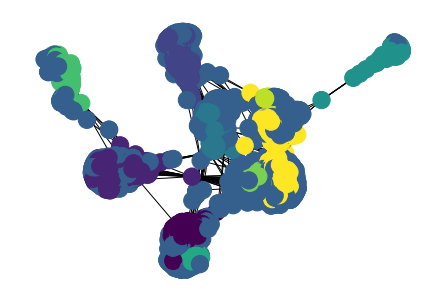

In [6]:
# values to cluster
U = eigen_vectors[:, :n_clusters]

# Low rank representation with the first n eigenvectors
k_means = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(U)
labels = k_means.labels_

# draw full graph
nx.draw(G, node_color=labels)
plt.show()

### 1.2 - Scikit-learn Spectral Clustering

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


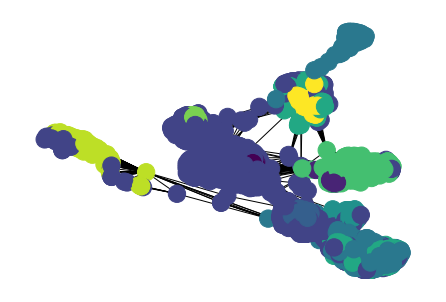

In [7]:
# values to cluster
U = eigen_vectors[:, :n_clusters]

# Scikit-learn Spectral Clustering
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0).fit(U)
labels = sc.labels_

# draw full graph
nx.draw(G, node_color=labels)
plt.show()

### 1.3 - Spark Power Iteration CLustering

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/07 01:53:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
SIMILARITIES DONE.


23/06/07 01:53:19 WARN BlockManager: Block rdd_6_1 already exists on this machine; not re-adding it
23/06/07 01:53:19 WARN BlockManager: Block rdd_6_1 already exists on this machine; not re-adding it
23/06/07 01:53:19 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
23/06/07 01:53:19 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it


POWER ITERATION CLUSTERING COMPUTED.


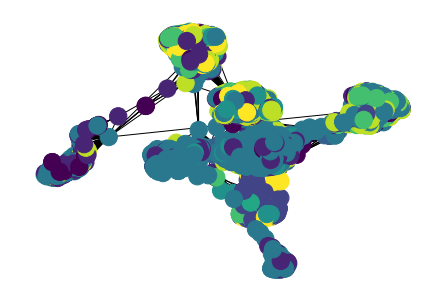

In [8]:
# SparkContext
sc = SparkContext(appName="PowerIterationClusteringExample")

# get data and map to tuples
data = sc.textFile(PATH_DATA)
similarities = data.map(lambda line: tuple([float(x) for x in line.split(split_char)]) + (1.0,))

print("SIMILARITIES DONE.")

# Cluster the data into classes using PowerIterationClustering
model = PowerIterationClustering.train(similarities, n_clusters, maxIterations=10)

print("POWER ITERATION CLUSTERING COMPUTED.")

# sort assigments by node id
sorted_assignments = sorted(model.assignments().collect(), key=lambda x: x.id)

# get labels of each node
labels = []
for x in sorted_assignments:
    labels.append(x.cluster)

# draw full graph
nx.draw(G, node_color=labels)
plt.show()

# stop spark context
sc.stop()